In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('google.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...,...
3267,2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000
3268,2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300
3269,2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,19523200
3270,2022-12-29,86.620003,88.849998,86.610001,88.449997,88.449997,23333500


# EDA

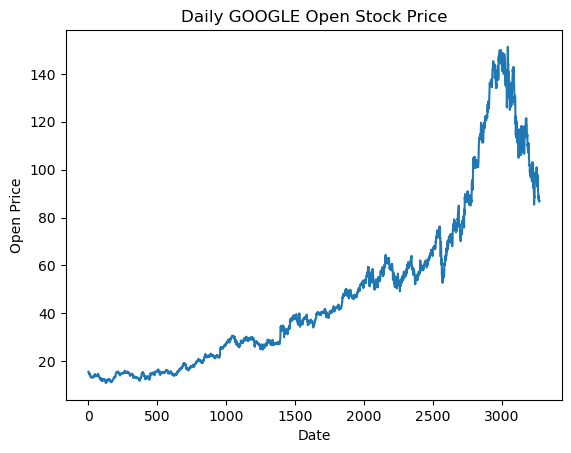

In [4]:
# Plot the time series
plt.plot(df['Open'])
plt.title('Daily GOOGLE Open Stock Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

In [5]:
# df["Date"] = df.index
df.reset_index(drop=True, inplace=True)

In [6]:
df = df[['Date', 'Close']]


# Stationarity tests

In [7]:
# stationarity check on data
from statsmodels.tsa.stattools import adfuller
def adf_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fail to reject the null hypothesis. Data is not stationary")

adf_test(df['Close'])

ADF Statistic: -0.630788
p-value: 0.863872
Fail to reject the null hypothesis. Data is not stationary


<Figure size 640x480 with 0 Axes>

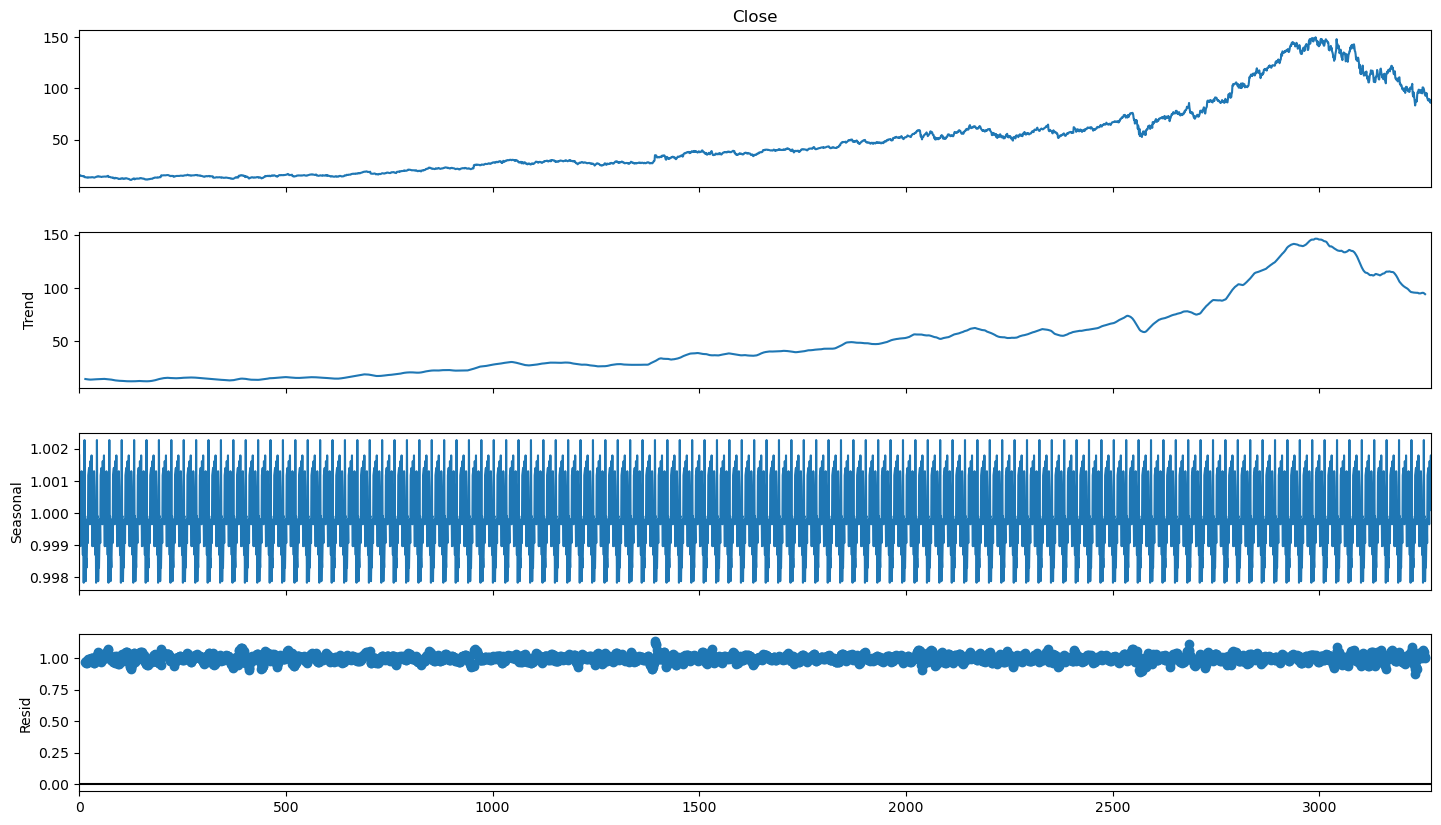

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Example 'Close' series
# Close = pd.Series(data, index=pd.date_range(start="YYYY-MM-DD", periods=N, freq="D"))
Close = df['Close']
# Seasonal decomposition
result = seasonal_decompose(Close, model='multiplicative', period=30)

# Plot results
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()


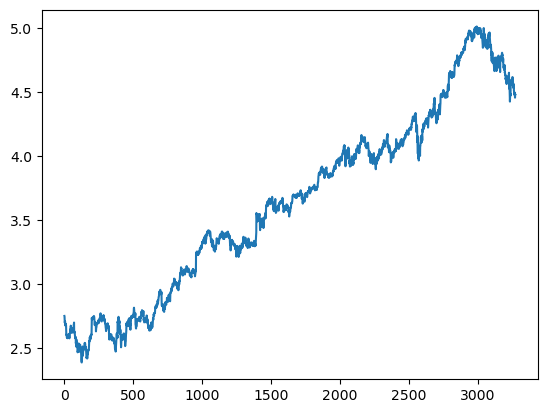

In [19]:
# Attempt to eliminate rend by taking log
log_closed = np.log(df['Close'])

plt.plot(log_closed)

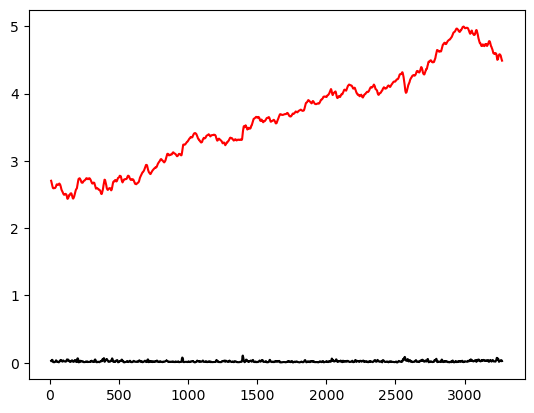

In [20]:
# Take a look at 12-month moving average
moving_avg = log_closed.rolling(12).mean()
std_dev = log_closed.rolling(12).std()

plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")

In [25]:
split_index = int(len(log_closed) * 0.9)
train_closed = df['Close'][:split_index]
test_closed= df['Close'][split_index:]

# Same split for log
train_log_closed = log_closed[:split_index]
test_log_closed = log_closed[split_index:]

ADF Statistic (d=0): 0.678245
p-value (d=0): 0.989394
ADF Statistic (d=1): -18.305675
p-value (d=1): 0.000000


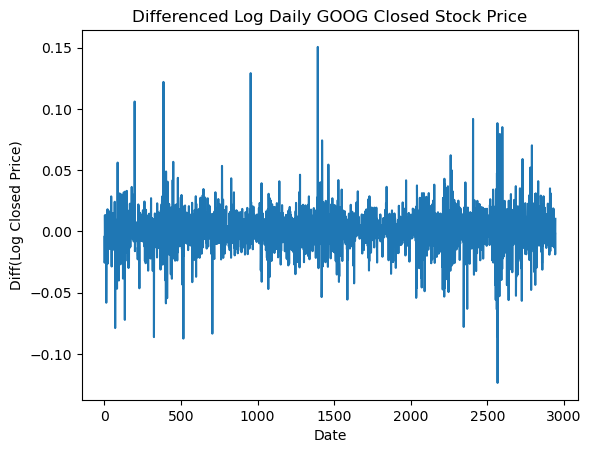

In [27]:
split_index = int(len(log_closed) * 0.9)
train_closed = df['Close'][:split_index]
test_closed = df['Close'][split_index:]

# Same split for log
train_log_closed = log_closed[:split_index]
test_log_closed = log_closed[split_index:]

# Taking first difference on train set
diff_train_log_closed = train_log_closed.diff().dropna()

# Look at ADF test
adf_test_diff0 = adfuller(train_log_closed)
print('ADF Statistic (d=0): %f' % adf_test_diff0[0])
print('p-value (d=0): %f' % adf_test_diff0[1])

# ADF test on differenced series
adf_test_diff1 = adfuller(diff_train_log_closed)
print('ADF Statistic (d=1): %f' % adf_test_diff1[0])
print('p-value (d=1): %f' % adf_test_diff1[1])

# Plotting the differenced series
plt.plot(diff_train_log_closed)
plt.title('Differenced Log Daily GOOG Closed Stock Price')
plt.xlabel('Date')
plt.ylabel('Diff(Log Closed Price)')
plt.show()


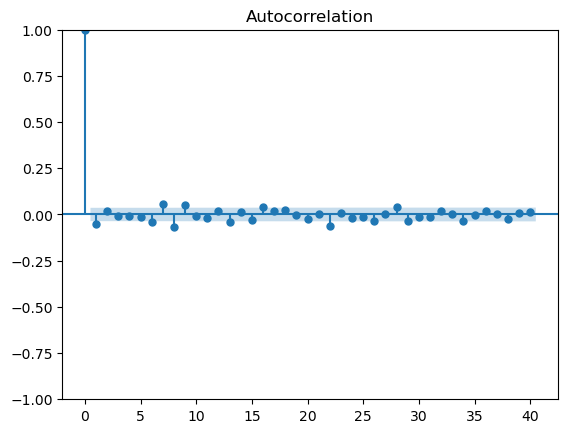

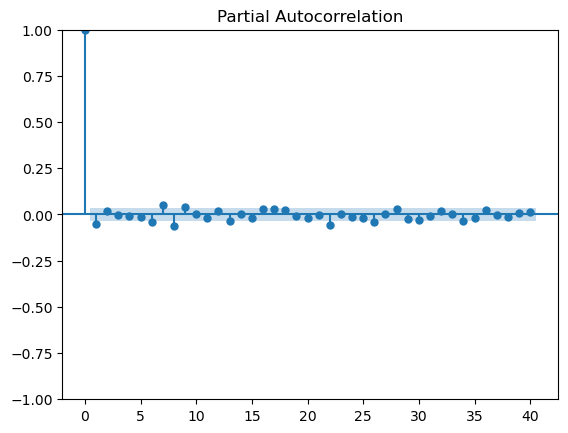

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff_train_log_closed, lags=40)
plot_pacf(diff_train_log_closed, lags=40)
plt.show()

# 1.Exponential Smoothing

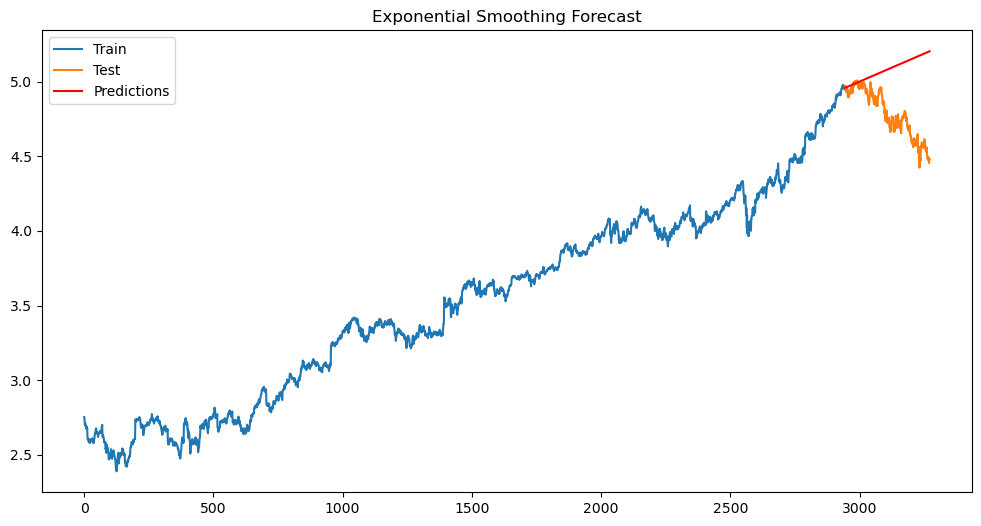

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 2944
Model:             ExponentialSmoothing   SSE                              0.774
Optimized:                         True   AIC                         -24262.752
Trend:                         Additive   BIC                         -24238.801
Seasonal:                          None   AICC                        -24262.723
Seasonal Periods:                  None   Date:                 Sun, 29 Dec 2024
Box-Cox:                          False   Time:                         21:28:57
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9506025                alpha                 True
smoothing_trend             0.0000

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Assuming 'train_log_open' is your time series data
model_exp_smooth = ExponentialSmoothing(train_log_closed, trend='add', seasonal=None, damped_trend=False)
model_exp_smooth_fitted = model_exp_smooth.fit()

# Make predictions
predictions = model_exp_smooth_fitted.forecast(len(test_log_closed))

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_log_closed, label='Train')
plt.plot(test_log_closed, label='Test')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

print(model_exp_smooth_fitted.summary())


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate the metrics
mse = mean_squared_error(test_log_closed, predictions)
mae = mean_absolute_error(test_log_closed, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_log_closed - predictions) / test_log_closed)) * 100

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Squared Error (MSE): 0.1372
Mean Absolute Error (MAE): 0.2946
Root Mean Squared Error (RMSE): 0.3705
Mean Absolute Percentage Error (MAPE): 6.32%


# 2.Moving Average 

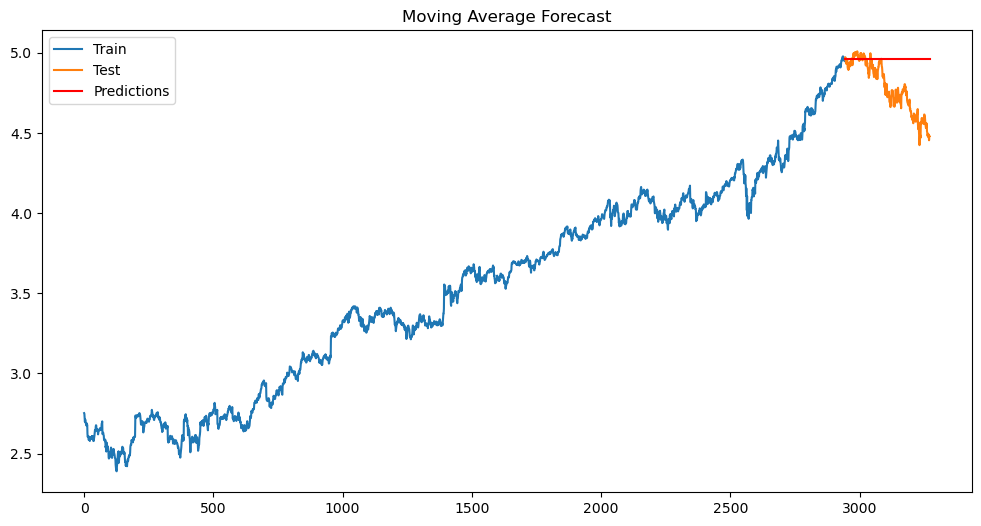

Mean Squared Error (MSE): 0.0557
Mean Absolute Error (MAE): 0.1817
Root Mean Squared Error (RMSE): 0.2359
Mean Absolute Percentage Error (MAPE): 3.91%


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Moving Average Forecast
window_size = 5  # Define the window size
train_moving_avg = train_log_closed.rolling(window=window_size).mean()

# Forecast using the last value of the moving average
forecast_start = len(train_log_closed)
forecast_end = forecast_start + len(test_log_closed) - 1
moving_avg_forecast = pd.Series(train_moving_avg.iloc[-1], index=range(forecast_start, forecast_end + 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_log_closed, label='Train')
plt.plot(test_log_closed, label='Test')
plt.plot(moving_avg_forecast.index, moving_avg_forecast, label='Predictions', color='red')
plt.legend()
plt.title('Moving Average Forecast')
plt.show()

# Calculate the metrics
mse = mean_squared_error(test_log_closed, moving_avg_forecast)
mae = mean_absolute_error(test_log_closed, moving_avg_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_log_closed - moving_avg_forecast) / test_log_closed)) * 100

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# 3.AR Model

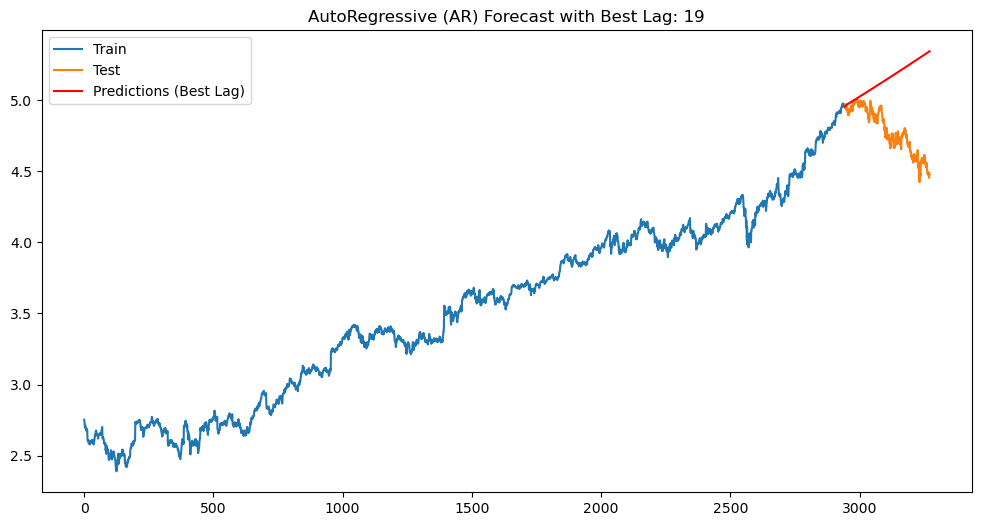

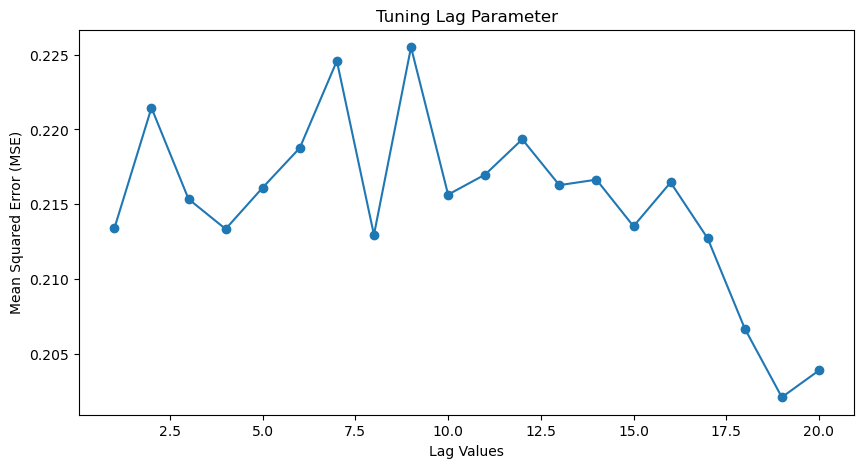

Best Lag: 19
Best Mean Squared Error (MSE): 0.2021
Mean Absolute Error (MAE): 0.3633
Root Mean Squared Error (RMSE): 0.4496
Mean Absolute Percentage Error (MAPE): 7.78%


In [37]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the best model and error
best_lag = None
best_mse = float('inf')
errors = []

# Range of lags to test
lag_values = range(1, 21)  # Test lag values from 1 to 20

for lag in lag_values:
    try:
        # Train the AR model with the current lag
        model_ar = AutoReg(train_log_closed, lags=lag)
        model_ar_fitted = model_ar.fit()
        
        # Make predictions
        predictions_ar = model_ar_fitted.predict(start=len(train_log_closed), 
                                                 end=len(train_log_closed) + len(test_log_closed) - 1)
        
        # Calculate the Mean Squared Error
        mse = mean_squared_error(test_log_closed, predictions_ar)
        errors.append(mse)
        
        # Update the best lag if the current lag gives a lower MSE
        if mse < best_mse:
            best_mse = mse
            best_lag = lag
    except Exception as e:
        # Handle potential errors (e.g., if lag is too large for the data)
        print(f"Error with lag {lag}: {e}")
        errors.append(None)

# Train the final model with the best lag
model_ar = AutoReg(train_log_closed, lags=best_lag)
model_ar_fitted = model_ar.fit()
predictions_ar = model_ar_fitted.predict(start=len(train_log_closed), 
                                         end=len(train_log_closed) + len(test_log_closed) - 1)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_log_closed, label='Train')
plt.plot(test_log_closed, label='Test')
plt.plot(predictions_ar.index, predictions_ar, label='Predictions (Best Lag)', color='red')
plt.legend()
plt.title(f'AutoRegressive (AR) Forecast with Best Lag: {best_lag}')
plt.show()

# Plot the MSE vs. Lag values
plt.figure(figsize=(10, 5))
plt.plot(lag_values, errors, marker='o', linestyle='-')
plt.xlabel('Lag Values')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Tuning Lag Parameter')
plt.show()

# Print the best lag and corresponding MSE
print(f"Best Lag: {best_lag}")
print(f"Best Mean Squared Error (MSE): {best_mse:.4f}")

# Calculate and display other metrics for the best lag
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_log_closed, predictions_ar)
rmse = np.sqrt(best_mse)
mape = np.mean(np.abs((test_log_closed - predictions_ar) / test_log_closed)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# 4.ARIMA 

C:\Users\lenovo1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lenovo1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


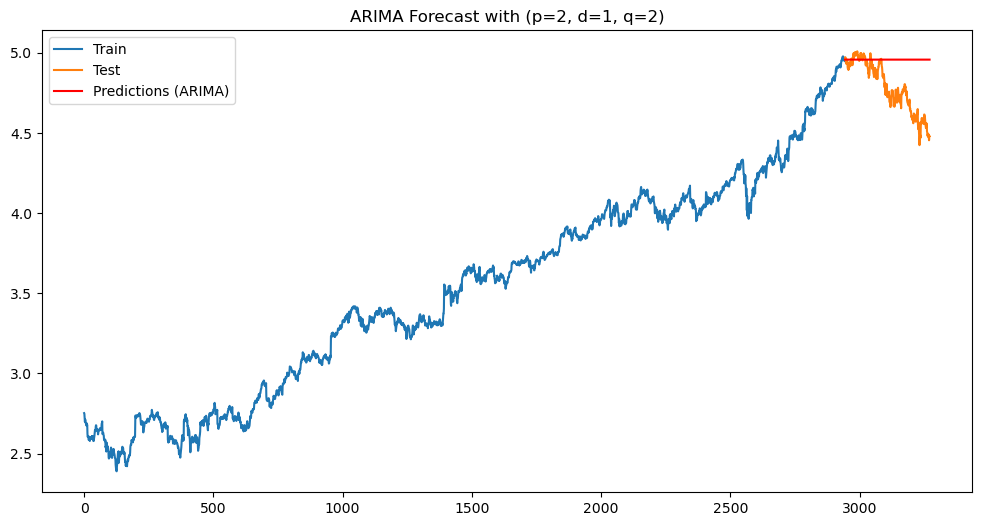

Mean Squared Error (MSE): 0.0540
Mean Absolute Error (MAE): 0.1783
Root Mean Squared Error (RMSE): 0.2323
Mean Absolute Percentage Error (MAPE): 3.83%


In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Fit ARIMA model
p, d, q = 2, 1, 2
model_arima = ARIMA(train_log_closed, order=(p, d, q))
model_arima_fitted = model_arima.fit()

# Make predictions
start = len(train_log_closed)
end = start + len(test_log_closed) - 1
predictions_arima = model_arima_fitted.predict(start=start, end=end, typ='levels')  # Use typ='levels' for transformed data

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_log_closed, label='Train')
plt.plot(test_log_closed, label='Test')
plt.plot(predictions_arima.index, predictions_arima, label='Predictions (ARIMA)', color='red')
plt.legend()
plt.title(f'ARIMA Forecast with (p={p}, d={d}, q={q})')
plt.show()

# Calculate metrics
mse = mean_squared_error(test_log_closed, predictions_arima)
mae = mean_absolute_error(test_log_closed, predictions_arima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_log_closed - predictions_arima) / test_log_closed)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


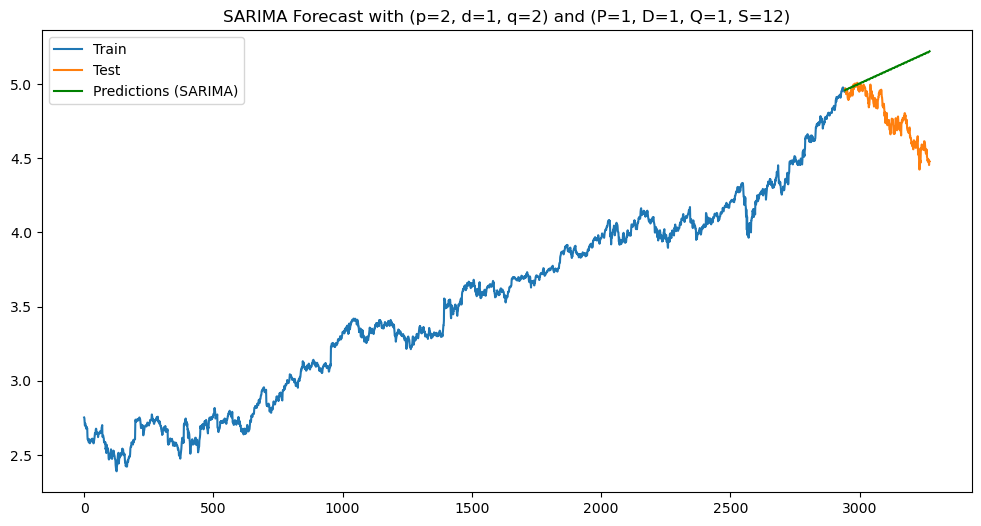

Mean Squared Error (MSE): 0.1446
Mean Absolute Error (MAE): 0.3033
Root Mean Squared Error (RMSE): 0.3803
Mean Absolute Percentage Error (MAPE): 6.50%


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Fit SARIMA model
P, D, Q, S = 1, 1, 1, 12  # Example seasonal parameters (adjust these based on your data)
p, d, q = 2, 1, 2  # Non-seasonal ARIMA parameters
model_sarima = SARIMAX(train_log_closed, order=(p, d, q), seasonal_order=(P, D, Q, S))
model_sarima_fitted = model_sarima.fit()

# Make predictions
start = len(train_log_closed)
end = start + len(test_log_closed) - 1
predictions_sarima = model_sarima_fitted.predict(start=start, end=end, typ='levels')  # Use typ='levels' for transformed data

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_log_closed, label='Train')
plt.plot(test_log_closed, label='Test')
plt.plot(predictions_sarima.index, predictions_sarima, label='Predictions (SARIMA)', color='green')
plt.legend()
plt.title(f'SARIMA Forecast with (p={p}, d={d}, q={q}) and (P={P}, D={D}, Q={Q}, S={S})')
plt.show()

# Calculate metrics
mse = mean_squared_error(test_log_closed, predictions_sarima)
mae = mean_absolute_error(test_log_closed, predictions_sarima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_log_closed - predictions_sarima) / test_log_closed)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# CONCLUSION

Sarima performs well as captured because it captures seasonality